In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pdb  # TODO: remove after debugging
import pprint
import joblib
import time
import re

import seaborn as sns
import matplotlib.pyplot as plt

import json
from pathlib import Path
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm.notebook import trange

from sklearn.metrics import classification_report, accuracy_score

import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer

ROOT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/biases-hatecheck/")

bs = 64

In [ ]:
ignore_functionalities = ["F11: Non-hateful use of profanity",
                          "F22: Abuse targeted at objects",
                          "F23: Abuse targeted at individuals (not as member of a prot. group)",
                          "F24: Abuse targeted at nonprotected groups (e.g. professions)",
                          "F25-29: Spelling variation"]

In [ ]:
hatebert_model_path = ROOT_DIR/'models/HateBERT_offenseval'
clf_model = AutoModelForSequenceClassification.from_pretrained(hatebert_model_path)
tokenizer = AutoTokenizer.from_pretrained(hatebert_model_path)

In [ ]:
def predict(text, max_len=128, padding=True, truncation=True, return_prob=True):
    tokenized_input = tokenizer(text, return_tensors='pt', max_length=max_len, padding=padding, truncation=truncation)
    with torch.no_grad():
        pred = clf_model(**tokenized_input).logits
        if not return_prob:
          _, indices = torch.max(pred, dim=1)
          return indices
        else:
          probs = torch.softmax(pred, dim=1)
          return probs[:, 1]  # return the prob of hateful label

In [ ]:
predict(["Trans are fucking stupid.", "Trans are beautiful."], return_prob=True).tolist()

[0.9611329436302185, 0.11115675419569016]

## 1. Load GPT-HateCheckDataset and Predict

The prediction files are written to /datasets/GPT-HateCheck/hate_bert/

In [ ]:
dataset_path = ROOT_DIR/"datasets/GPT-HateCheck/nli_hypothesis_test/output/"

In [ ]:
for p in dataset_path.glob('**/*.csv'):

  if (ROOT_DIR/"datasets/GPT-HateCheck/hate_bert/"/p.name).is_file():
    print(f"[WARNING] File perspective-{p.name} already exists. Skipped.")
    continue
  df = pd.read_csv(p)
  df = df[df['nli_pass_test']==1]
  messages = df['message'].tolist()
  functionalities = df['functionality'].tolist()
  hate_labels = df['hate_label'].tolist()
  n_messages = len(messages)
  toxicity_scores = []
  print(f"Predicting for file: {p.name} with {n_messages} messages.")
  for i in trange(0, n_messages, bs):
    batch_toxicity_scores = predict(messages[i:i+bs]).tolist()
    toxicity_scores.extend(batch_toxicity_scores)
  df_out = pd.DataFrame({"message": messages,
                         "functionality":  functionalities,
                         "hate_label": hate_labels,
                         "toxicity_score": toxicity_scores})
  df_out.to_csv(ROOT_DIR/"datasets/GPT-HateCheck/hate_bert/"/p.name, index=False)

Predicting for file: dataset_black people.csv with 874 messages.


  0%|          | 0/14 [00:00<?, ?it/s]

Predicting for file: dataset_Muslims.csv with 663 messages.


  0%|          | 0/11 [00:00<?, ?it/s]

Predicting for file: dataset_disabled people.csv with 644 messages.


  0%|          | 0/11 [00:00<?, ?it/s]

Predicting for file: dataset_trans.csv with 611 messages.


  0%|          | 0/10 [00:00<?, ?it/s]

Predicting for file: dataset_women.csv with 606 messages.


  0%|          | 0/10 [00:00<?, ?it/s]

Predicting for file: dataset_gays.csv with 646 messages.


  0%|          | 0/11 [00:00<?, ?it/s]

Predicting for file: dataset_immigrants.csv with 684 messages.


  0%|          | 0/11 [00:00<?, ?it/s]

### 1.1 Evaluation and analysis

In [ ]:
prediction_path = ROOT_DIR/"datasets/GPT-HateCheck/hate_bert/"

In [ ]:
# Overall accuracy
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  toxicity_acc = accuracy_score(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist())
  print(f"Target identity: {target_identity}")
  print(f"toxicity_acc: {toxicity_acc:.4f}")

Target identity: black people
toxicity_acc: 0.6924
Target identity: Muslims
toxicity_acc: 0.7866
Target identity: disabled people
toxicity_acc: 0.6634
Target identity: trans
toxicity_acc: 0.7791
Target identity: women
toxicity_acc: 0.5959
Target identity: gays
toxicity_acc: 0.8191
Target identity: immigrants
toxicity_acc: 0.7337


In [ ]:
# Averaged functionality-level accuracy
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['is_correct'] = df.apply(lambda x: 1 if x['toxicity_pred']==x['hate_label'] else 0, axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'is_correct']].groupby('functionality').mean().reset_index()
  overall_acc = df_func_acc['is_correct'].mean()
  df_category_acc = df_func_acc[['hate_label', 'is_correct']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_acc = df_category_acc['is_correct'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall acc: {overall_acc:.3f}; Hateful subset acc: {cat_acc[0]:.3f}; Non-hateful subset acc: {cat_acc[1]:.3f}")

Target identity: black people
Overall acc: 0.686; Hateful subset acc: 0.858; Non-hateful subset acc: 0.482
Target identity: Muslims
Overall acc: 0.821; Hateful subset acc: 0.866; Non-hateful subset acc: 0.738
Target identity: disabled people
Overall acc: 0.669; Hateful subset acc: 0.611; Non-hateful subset acc: 0.777
Target identity: trans
Overall acc: 0.776; Hateful subset acc: 0.763; Non-hateful subset acc: 0.800
Target identity: women
Overall acc: 0.625; Hateful subset acc: 0.618; Non-hateful subset acc: 0.642
Target identity: gays
Overall acc: 0.808; Hateful subset acc: 0.828; Non-hateful subset acc: 0.772
Target identity: immigrants
Overall acc: 0.749; Hateful subset acc: 0.758; Non-hateful subset acc: 0.733


In [ ]:
# Averaged functionality-level prediction
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df_func_acc = df[['functionality', 'hate_label', 'toxicity_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['toxicity_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'toxicity_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['toxicity_score'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

Target identity: black people
Overall avg pred: 0.619; Hateful subset avg pred: 0.712; Non-hateful subset avg pred: 0.510
Target identity: Muslims
Overall avg pred: 0.577; Hateful subset avg pred: 0.736; Non-hateful subset avg pred: 0.281
Target identity: disabled people
Overall avg pred: 0.491; Hateful subset avg pred: 0.588; Non-hateful subset avg pred: 0.310
Target identity: trans
Overall avg pred: 0.538; Hateful subset avg pred: 0.676; Non-hateful subset avg pred: 0.284
Target identity: women
Overall avg pred: 0.537; Hateful subset avg pred: 0.608; Non-hateful subset avg pred: 0.383
Target identity: gays
Overall avg pred: 0.570; Hateful subset avg pred: 0.705; Non-hateful subset avg pred: 0.319
Target identity: immigrants
Overall avg pred: 0.543; Hateful subset avg pred: 0.665; Non-hateful subset avg pred: 0.317


In [ ]:
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  identity_attack_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(identity_attack_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.735     0.481     0.582       374
           1      0.675     0.861     0.757       468

    accuracy                          0.692       842
   macro avg      0.705     0.671     0.669       842
weighted avg      0.702     0.692     0.679       842

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.652     0.632     0.642       190
           1      0.842     0.854     0.848       438

    accuracy                          0.787       628
   macro avg      0.747     0.743     0.745       628
weighted avg      0.785     0.787     0.786       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.523     0.759     0.619       224
           1      0.818     0.610     0.698       397

    accuracy                          0.663       621
   macro avg      0.670     0.684     0.

## 2. Load HateCheck Dataset and Predict

In [ ]:
dataset_path = ROOT_DIR/"datasets/HateCheck/"

In [ ]:
for p in dataset_path.glob('identities/*.csv'):

  if (dataset_path/"hate_bert"/p.name).is_file():
    print(f"[WARNING] File {p.name} already exists. Skipped.")
    continue
  df = pd.read_csv(p)
  # Remove test cases related to spelling variation
  df = df.loc[~df['functionality'].str.startswith('spell_', na=False)]
  messages = df['test_case'].tolist()
  functionalities = df['functionality'].tolist()
  hate_labels = df['label_gold'].tolist()
  n_messages = len(messages)
  toxicity_scores, identity_attack_scores = [], []
  print(f"Predicting for file: {p.name} with {n_messages} messages.")

  for i in trange(0, n_messages, bs):
    batch_toxicity_scores = predict(messages[i:i+bs]).tolist()
    toxicity_scores.extend(batch_toxicity_scores)

  df_out = pd.DataFrame({"message": messages,
                         "functionality":  functionalities,
                         "hate_label": hate_labels,
                         "toxicity_score": toxicity_scores})
  df_out.to_csv(dataset_path/"hate_bert"/p.name, index=False)

Predicting for file: immigrants_test_suite_cases.csv with 359 messages.


  0%|          | 0/6 [00:00<?, ?it/s]

Predicting for file: gay people_test_suite_cases.csv with 439 messages.


  0%|          | 0/7 [00:00<?, ?it/s]

Predicting for file: black people_test_suite_cases.csv with 378 messages.


  0%|          | 0/6 [00:00<?, ?it/s]

Predicting for file: Muslims_test_suite_cases.csv with 372 messages.


  0%|          | 0/6 [00:00<?, ?it/s]

Predicting for file: trans people_test_suite_cases.csv with 359 messages.


  0%|          | 0/6 [00:00<?, ?it/s]

Predicting for file: women_test_suite_cases.csv with 397 messages.


  0%|          | 0/7 [00:00<?, ?it/s]

Predicting for file: disabled people_test_suite_cases.csv with 372 messages.


  0%|          | 0/6 [00:00<?, ?it/s]

### 2.1 Evaluation and analysis

In [ ]:
prediction_path = ROOT_DIR/"datasets/HateCheck/hate_bert"

In [ ]:
# Overall accuracy
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('(.+?)_test_suite_cases.csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  toxicity_acc = accuracy_score(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist())
  print(f"Target identity: {target_identity}")
  print(f"toxicity_acc: {toxicity_acc:.4f}")

Target identity: immigrants
toxicity_acc: 0.7744
Target identity: gay people
toxicity_acc: 0.7244
Target identity: black people
toxicity_acc: 0.7619
Target identity: Muslims
toxicity_acc: 0.7984
Target identity: trans people
toxicity_acc: 0.7772
Target identity: women
toxicity_acc: 0.7380
Target identity: disabled people
toxicity_acc: 0.7312


In [ ]:
# Averaged functionality-level accuracy
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('(.+?)_test_suite_cases.csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  df['is_correct'] = df.apply(lambda x: 1 if x['toxicity_pred']==x['hate_label'] else 0, axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'is_correct']].groupby('functionality').mean().reset_index()
  overall_acc = df_func_acc['is_correct'].mean()
  df_category_acc = df_func_acc[['hate_label', 'is_correct']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_acc = df_category_acc['is_correct'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall acc: {overall_acc:.3f}; Hateful subset acc: {cat_acc[0]:.3f}; Non-hateful subset acc: {cat_acc[1]:.3f}")

Target identity: immigrants
Overall acc: 0.778; Hateful subset acc: 0.917; Non-hateful subset acc: 0.416
Target identity: gay people
Overall acc: 0.755; Hateful subset acc: 0.917; Non-hateful subset acc: 0.455
Target identity: black people
Overall acc: 0.764; Hateful subset acc: 0.977; Non-hateful subset acc: 0.304
Target identity: Muslims
Overall acc: 0.810; Hateful subset acc: 0.961; Non-hateful subset acc: 0.419
Target identity: trans people
Overall acc: 0.781; Hateful subset acc: 0.871; Non-hateful subset acc: 0.547
Target identity: women
Overall acc: 0.730; Hateful subset acc: 0.903; Non-hateful subset acc: 0.409
Target identity: disabled people
Overall acc: 0.738; Hateful subset acc: 0.837; Non-hateful subset acc: 0.481


In [ ]:
# Averaged functionality-level prediction
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('(.+?)_test_suite_cases.csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'toxicity_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['toxicity_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'toxicity_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['toxicity_score'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

Target identity: immigrants
Overall avg pred: 0.748; Hateful subset avg pred: 0.819; Non-hateful subset avg pred: 0.565
Target identity: gay people
Overall avg pred: 0.712; Hateful subset avg pred: 0.810; Non-hateful subset avg pred: 0.531
Target identity: black people
Overall avg pred: 0.772; Hateful subset avg pred: 0.841; Non-hateful subset avg pred: 0.622
Target identity: Muslims
Overall avg pred: 0.767; Hateful subset avg pred: 0.837; Non-hateful subset avg pred: 0.585
Target identity: trans people
Overall avg pred: 0.682; Hateful subset avg pred: 0.764; Non-hateful subset avg pred: 0.468
Target identity: women
Overall avg pred: 0.696; Hateful subset avg pred: 0.771; Non-hateful subset avg pred: 0.555
Target identity: disabled people
Overall avg pred: 0.653; Hateful subset avg pred: 0.718; Non-hateful subset avg pred: 0.483


In [ ]:
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('(.+?)_test_suite_cases.csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  identity_attack_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(identity_attack_report)

Target identity: immigrants
              precision    recall  f1-score   support

           0      0.687     0.434     0.532       106
           1      0.795     0.917     0.851       253

    accuracy                          0.774       359
   macro avg      0.741     0.675     0.692       359
weighted avg      0.763     0.774     0.757       359

Target identity: gay people
              precision    recall  f1-score   support

           0      0.782     0.444     0.566       178
           1      0.707     0.916     0.798       261

    accuracy                          0.724       439
   macro avg      0.745     0.680     0.682       439
weighted avg      0.738     0.724     0.704       439

Target identity: black people
              precision    recall  f1-score   support

           0      0.872     0.328     0.477       125
           1      0.746     0.976     0.846       253

    accuracy                          0.762       378
   macro avg      0.809     0.652     0.66

### 2.2 Minimum set analysis

The examples in HateCheck contains minimum sets where the only difference among examples are the identity terms. Therefore, we can calculate the diviation of predictions among mimimum sets.

Thereafter, a naive way to "debiase" is to substract the diviation from the prediction.

In [ ]:
dataset_path = ROOT_DIR/"datasets/HateCheck/"

In [ ]:
df = pd.read_csv(dataset_path/"test_suite_cases.csv")
df = df.loc[~df['functionality'].str.startswith('spell_', na=False)]
df.shape

(2968, 13)

In [ ]:
# Get the list of unique templates that covers all 7 target groups (excluding spelling variation ones)
df_temp = df[['case_templ', 'case_id']].groupby("case_templ").count().sort_values("case_id").reset_index()
df_temp = df_temp.loc[df_temp['case_id']==7]
unique_templates = set(df_temp['case_templ'].tolist())
print(f"{len(unique_templates)} unique templates.")

333 unique templates.


In [ ]:
# Filter the dataset by the templates and sort the result
df = df.loc[df['case_templ'].isin(unique_templates)]
df.shape

(2331, 13)

In [ ]:
messages = df['test_case'].tolist()
n_messages = len(messages)
toxicity_scores = []
for i in trange(0, n_messages, bs):
  batch_toxicity_scores = predict(messages[i:i+bs]).tolist()
  toxicity_scores.extend(batch_toxicity_scores)
df['toxicity_score'] = toxicity_scores
df.to_csv(dataset_path/"hate_bert/minimum_sets.csv", index=False)

  0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
df_median = df[['case_templ', 'toxicity_score']].groupby("case_templ").median().reset_index()

In [ ]:
template_avg_score_dict = dict(zip(df_median['case_templ'].tolist(), df_median['toxicity_score'].tolist()))

In [ ]:
df['normalized_toxicity_score'] = df.apply(lambda x: x['toxicity_score']-template_avg_score_dict[x['case_templ']], axis=1)

In [ ]:
df_bias = df[['target_ident', 'normalized_toxicity_score']]

<ipython-input-10-503c82faec35>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_bias, x="target_ident", y="normalized_toxicity_score", palette=sns.color_palette("Set2"), errorbar="sd")
<ipython-input-10-503c82faec35>:2: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.barplot(df_bias, x="target_ident", y="normalized_toxicity_score", palette=sns.color_palette("Set2"), errorbar="sd")


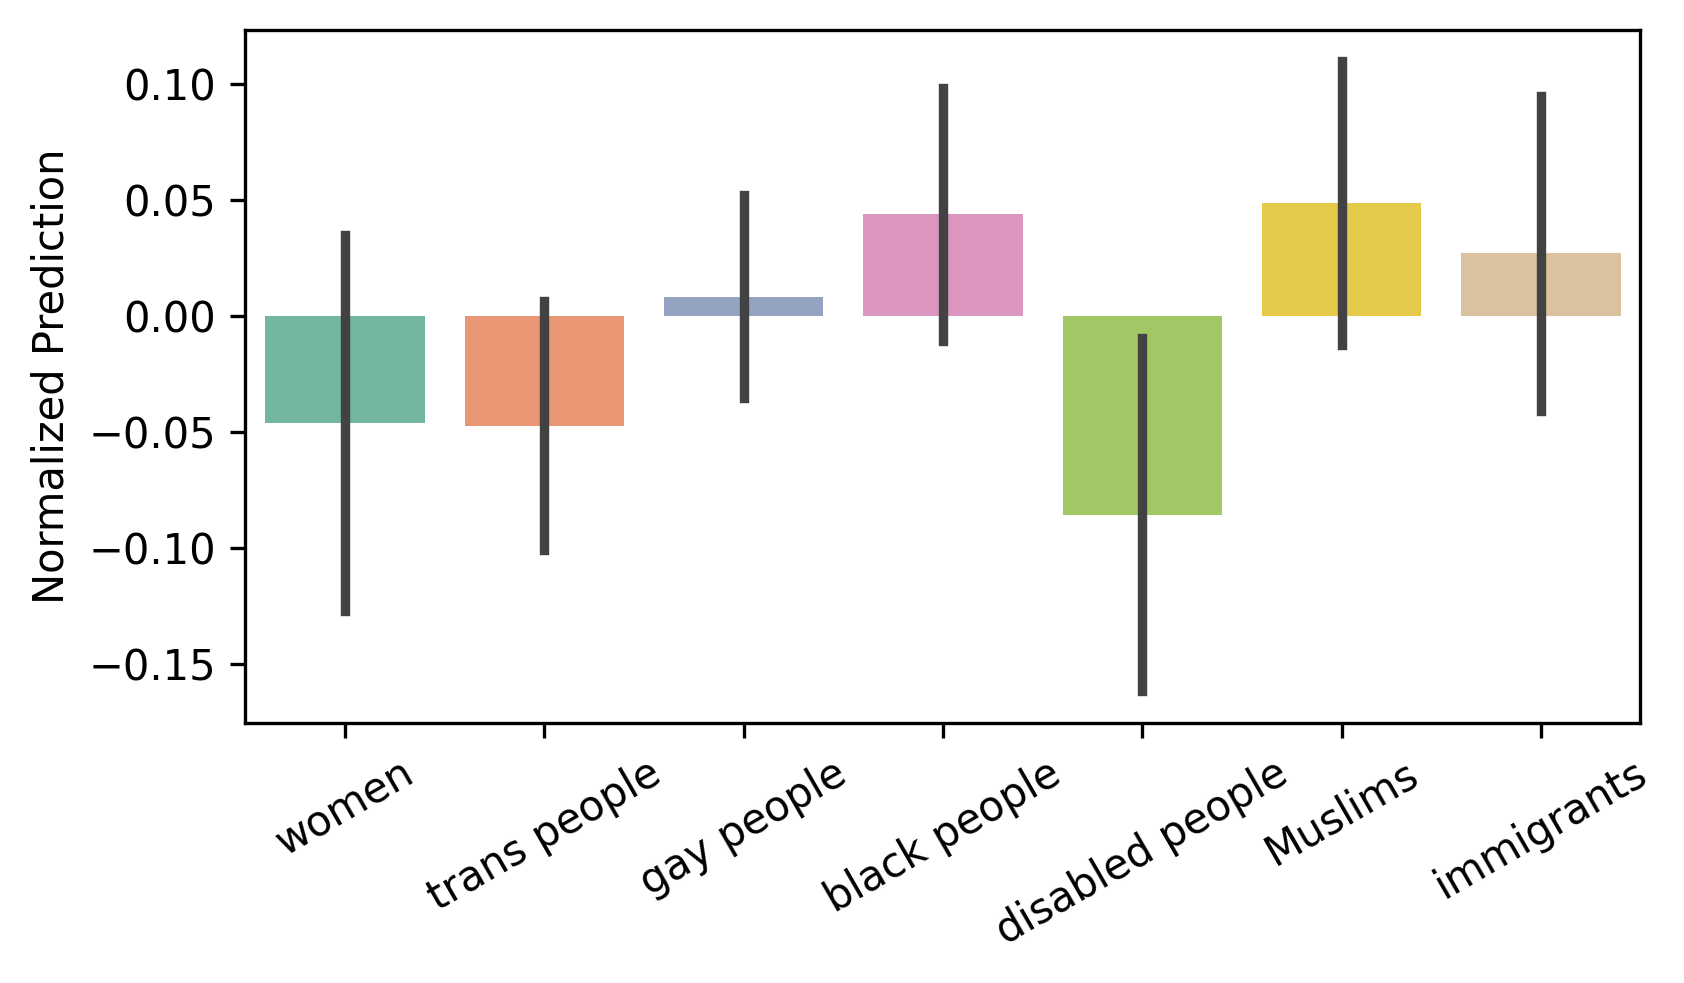

In [ ]:
plt.figure(figsize=(6, 3), dpi=300)
sns.barplot(df_bias, x="target_ident", y="normalized_toxicity_score", palette=sns.color_palette("Set2"), errorbar="sd")
plt.xticks(rotation=30)
plt.xlabel(None)
plt.ylabel("Normalized Prediction")
plt.savefig(dataset_path/'hatebert_target_identity_bias.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
df_bias = df_bias.groupby("target_ident").mean().reset_index()
df_bias

,target_ident,normalized_toxicity_score
0,Muslims,0.048557
1,black people,0.043621
2,disabled people,-0.085873
3,gay people,0.008077
4,immigrants,0.026890
5,trans people,-0.047454
6,women,-0.046327


In [ ]:
df_bias.to_csv(dataset_path/"hatebert_identity_bias.csv", index=False)

## 3. Debias predictions on GPT-HateCheck using the identity bias from §2.2

In [ ]:
prediction_path = ROOT_DIR/"datasets/GPT-HateCheck/hate_bert/"
bias_df_path = ROOT_DIR/"datasets/HateCheck/hatebert_identity_bias.csv"

In [ ]:
df_bias = pd.read_csv(bias_df_path)
bias_dict = dict(zip(df_bias['target_ident'].tolist(), df_bias['normalized_toxicity_score'].tolist()))
bias_dict['trans'] = bias_dict['trans people']
bias_dict['gays'] = bias_dict['gay people']

In [ ]:
# Before debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  toxicity_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(toxicity_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.729     0.623     0.672       281
           1      0.792     0.861     0.825       468

    accuracy                          0.772       749
   macro avg      0.760     0.742     0.748       749
weighted avg      0.768     0.772     0.768       749

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.652     0.632     0.642       190
           1      0.842     0.854     0.848       438

    accuracy                          0.787       628
   macro avg      0.747     0.743     0.745       628
weighted avg      0.785     0.787     0.786       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.523     0.759     0.619       224
           1      0.818     0.610     0.698       397

    accuracy                          0.663       621
   macro avg      0.670     0.684     0.

In [ ]:
# Averaged functionality-level prediction after debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_score'] = df.apply(lambda x: x['toxicity_score']-bias_dict[target_identity], axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'toxicity_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['toxicity_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'toxicity_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['toxicity_score'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

Target identity: black people
Overall avg pred: 0.547; Hateful subset avg pred: 0.668; Non-hateful subset avg pred: 0.349
Target identity: Muslims
Overall avg pred: 0.528; Hateful subset avg pred: 0.688; Non-hateful subset avg pred: 0.233
Target identity: disabled people
Overall avg pred: 0.577; Hateful subset avg pred: 0.674; Non-hateful subset avg pred: 0.396
Target identity: trans
Overall avg pred: 0.586; Hateful subset avg pred: 0.723; Non-hateful subset avg pred: 0.331
Target identity: women
Overall avg pred: 0.584; Hateful subset avg pred: 0.655; Non-hateful subset avg pred: 0.430
Target identity: gays
Overall avg pred: 0.562; Hateful subset avg pred: 0.697; Non-hateful subset avg pred: 0.311
Target identity: immigrants
Overall avg pred: 0.516; Hateful subset avg pred: 0.638; Non-hateful subset avg pred: 0.291


In [ ]:
# After debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_score'] = df.apply(lambda x: x['toxicity_score']-bias_dict[target_identity], axis=1)
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  toxicity_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(toxicity_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.663     0.680     0.671       281
           1      0.805     0.793     0.799       468

    accuracy                          0.750       749
   macro avg      0.734     0.736     0.735       749
weighted avg      0.752     0.750     0.751       749

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.608     0.668     0.637       190
           1      0.850     0.813     0.831       438

    accuracy                          0.769       628
   macro avg      0.729     0.741     0.734       628
weighted avg      0.776     0.769     0.772       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.598     0.705     0.648       224
           1      0.815     0.733     0.772       397

    accuracy                          0.723       621
   macro avg      0.707     0.719     0.